In [3]:
### distance and correlation heatmaps using either blasts or tubes data
import pandas as pd
import seaborn as sns
import scipy as sp
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

sns.set(style='white', context='notebook', rc={'figure.figsize':(12,10)}, font='sans-serif')

In [4]:
### Input and table cleaning
prof = pd.read_csv("C:\\Users\\lambr\\OneDrive - National University of Ireland, Galway\\CellPainting project data\\Harmony\\Nv6-PerWell\\blastsProfiles.csv")
prof = prof.dropna(axis=1)
prof.set_index(['Compound','Concentration','PlateName','Count'],inplace=True)
treat = prof.groupby(by=['Compound','Concentration']).mean()
treat.drop(columns=['Row','Column','Unnamed: 0'],inplace = True)

In [5]:
### DROP CORRELATED columns
cor_matrix = treat.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
treatFilt = treat.drop(columns=to_drop, axis=1)
treatFilt.reset_index(inplace=True)
indicesForDF = treatFilt['Compound']+"-"+treatFilt['Concentration'].astype(str)
treatFilt.set_index(['Compound','Concentration'], inplace=True)

In [6]:
### calculate inverted covariance matrix between PCA components
aggProfNP = treatFilt.to_numpy()
pca = PCA(n_components=0.9, svd_solver='full')
embed = pca.fit_transform(aggProfNP)

covMat = np.cov(embed, rowvar=False)
covMatInv = np.linalg.inv(covMat)
sampleSize=len(treatFilt.index)

In [7]:
### compute matrix of Mahalanobis distances
sample = []
mahaMat = np.empty(shape=[sampleSize,sampleSize])
for x in range(0,sampleSize):
    for y in range(0,sampleSize):
        sample.insert(y, sp.spatial.distance.mahalanobis(embed[x],embed[y], covMatInv)) # mahalanobis distance
    mahaMat[x] = sample
    sample = []
mahaDF = pd.DataFrame(mahaMat, index=treatFilt.index, columns=treatFilt.index)

In [8]:
### compute matrix of Pearson correlations
sample = []
pearsonMat = np.empty(shape=[sampleSize,sampleSize])
for x in range(0,sampleSize):
    for y in range(0,sampleSize):
        sample.insert(y,sp.stats.pearsonr(embed[x],embed[y])[0])    # pearson correlation
    pearsonMat[x] = sample
    sample = []
pearsonDF = pd.DataFrame(pearsonMat, index=treatFilt.index, columns=treatFilt.index)

In [9]:
### compute matrix of correlation distances
sample = []
corrMat = np.empty(shape=[sampleSize,sampleSize])
for x in range(0,sampleSize):
    for y in range(0,sampleSize):
        sample.insert(y,(sp.spatial.distance.correlation(embed[x],embed[y])))   # pearson correlation
    pearsonMat[x] = sample
    sample = []
corrDF = pd.DataFrame(corrMat, index=treatFilt.index.to_list(), columns=treatFilt.index.to_list())

In [10]:
### create table with positional information for drug labels on heatmap
heatmapInfo = pd.DataFrame(treat.reset_index().value_counts(['Compound'],sort=False),columns=['Values'])
heatmapInfo['Sum'] = heatmapInfo.cumsum()
heatmapInfo['Indices'] = heatmapInfo['Sum'] - heatmapInfo['Values']//2
heatmapInfo.reset_index(inplace=True)

In [11]:
### Plot correlation heatmap
palette = sns.color_palette("magma",as_cmap=True)
fig = sns.heatmap(corrMat,cmap=palette,square=True)

fig.set_xticks(heatmapInfo['Indices'])
fig.set_xticklabels(heatmapInfo.Compound.to_list())
fig.set_yticks(heatmapInfo['Indices'])
fig.set_yticklabels(heatmapInfo.Compound.to_list())

fig.hlines(heatmapInfo['Sum'], *fig.get_xlim(),color = 'grey',lw=0.6)
fig.vlines(heatmapInfo['Sum'], *fig.get_xlim(),color = 'grey',lw=0.6)

fig.set(xlabel= 'Drug & Concentration', ylabel='Drug & Concentration')

plt.tick_params(axis='x', labelbottom = False, bottom=False, top = True, labeltop=True, labelrotation = 90)
plt.tick_params(axis='y', labelbottom = False, bottom=False, left = True, labeltop=True, labelrotation = 0)
plt.figure(dpi=700)
fig

AttributeError: 'DataFrame' object has no attribute 'Compound'

Error in callback <function _draw_all_if_interactive at 0x0000025ADC729BD0> (for post_execute), with arguments args (),kwargs {}:


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 1200x1000 with 2 Axes>

<AxesSubplot: xlabel='Drug & Concentration', ylabel='Drug & Concentration'>

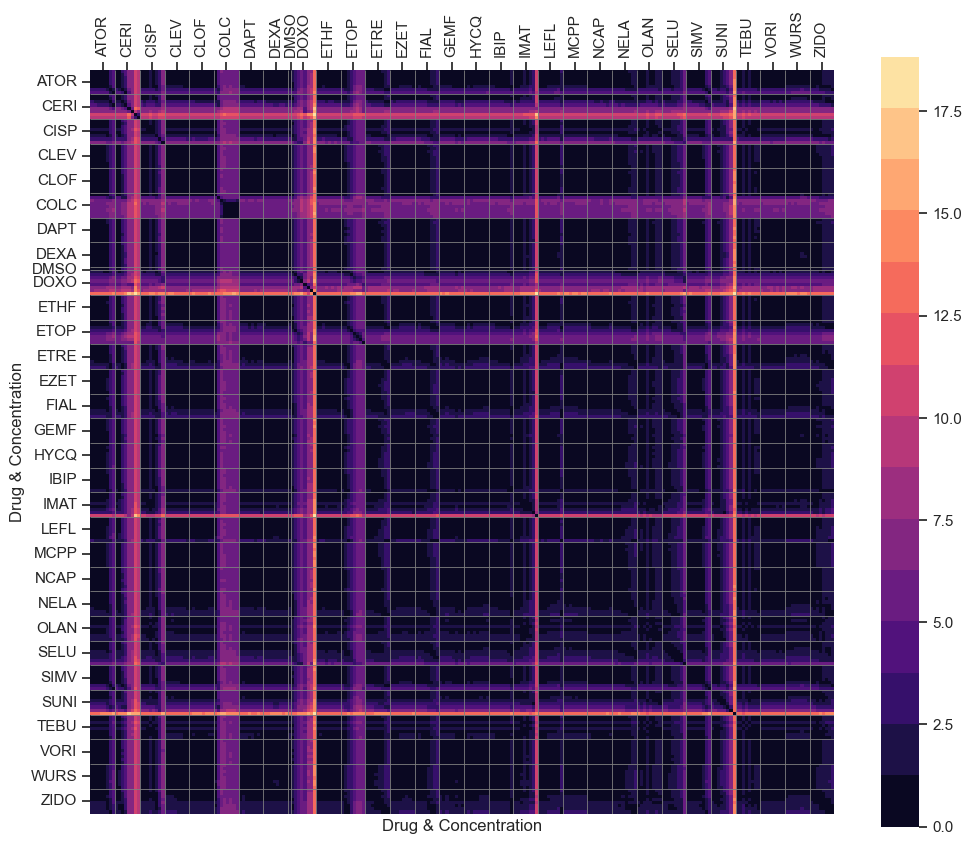

<Figure size 8400x7000 with 0 Axes>

In [ ]:
### Plot Mahalanobis heatmap
palette = sns.color_palette("magma",n_colors=15)
fig = sns.heatmap(mahaDF,cmap=palette,square=True)

fig.set_xticks(heatmapInfo['Indices'])
fig.set_xticklabels(heatmapInfo.Compound.to_list())
fig.set_yticks(heatmapInfo['Indices'])
fig.set_yticklabels(heatmapInfo.Compound.to_list())

fig.hlines(heatmapInfo['Sum'], *fig.get_xlim(),color = 'grey',lw=0.6)
fig.vlines(heatmapInfo['Sum'], *fig.get_xlim(),color = 'grey',lw=0.6)

fig.set(xlabel= 'Drug & Concentration', ylabel='Drug & Concentration')

plt.tick_params(axis='x', labelbottom = False, bottom=False, top = True, labeltop=True, labelrotation = 90,)
plt.tick_params(axis='y', labelbottom = False, bottom=False, left = True, labeltop=True, labelrotation = 0)
plt.figure(dpi=700,)
fig

<AxesSubplot: >

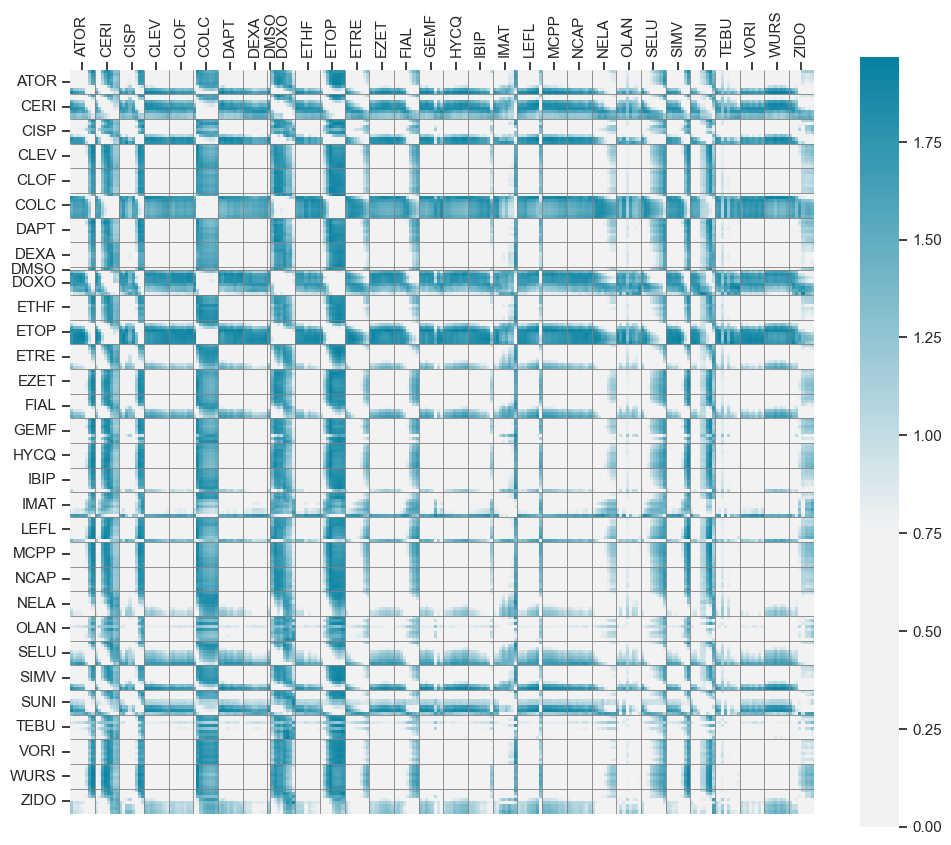

<Figure size 8400x7000 with 0 Axes>

In [ ]:
### Plot Pearson heatmap
palette = sns.diverging_palette(0, 225, s=99,sep=100, l=50, as_cmap=True)
fig = sns.heatmap(pearsonMat,cmap=palette,center =0.0,square=True)

fig.set_xticks(heatmapInfo['Indices'])
fig.set_xticklabels(heatmapInfo.Compound.to_list())
fig.set_yticks(heatmapInfo['Indices'])
fig.set_yticklabels(heatmapInfo.Compound.to_list())

fig.hlines(heatmapInfo['Sum'], *fig.get_xlim(),color = 'grey',lw=0.6)
fig.vlines(heatmapInfo['Sum'], *fig.get_xlim(),color = 'grey',lw=0.6)

plt.tick_params(axis='x', labelbottom = False, bottom=False, top = True, labeltop=True, labelrotation = 90,)
plt.tick_params(axis='y', labelbottom = False, bottom=False, left = True, labeltop=True, labelrotation = 0)
plt.figure(dpi=700)
fig

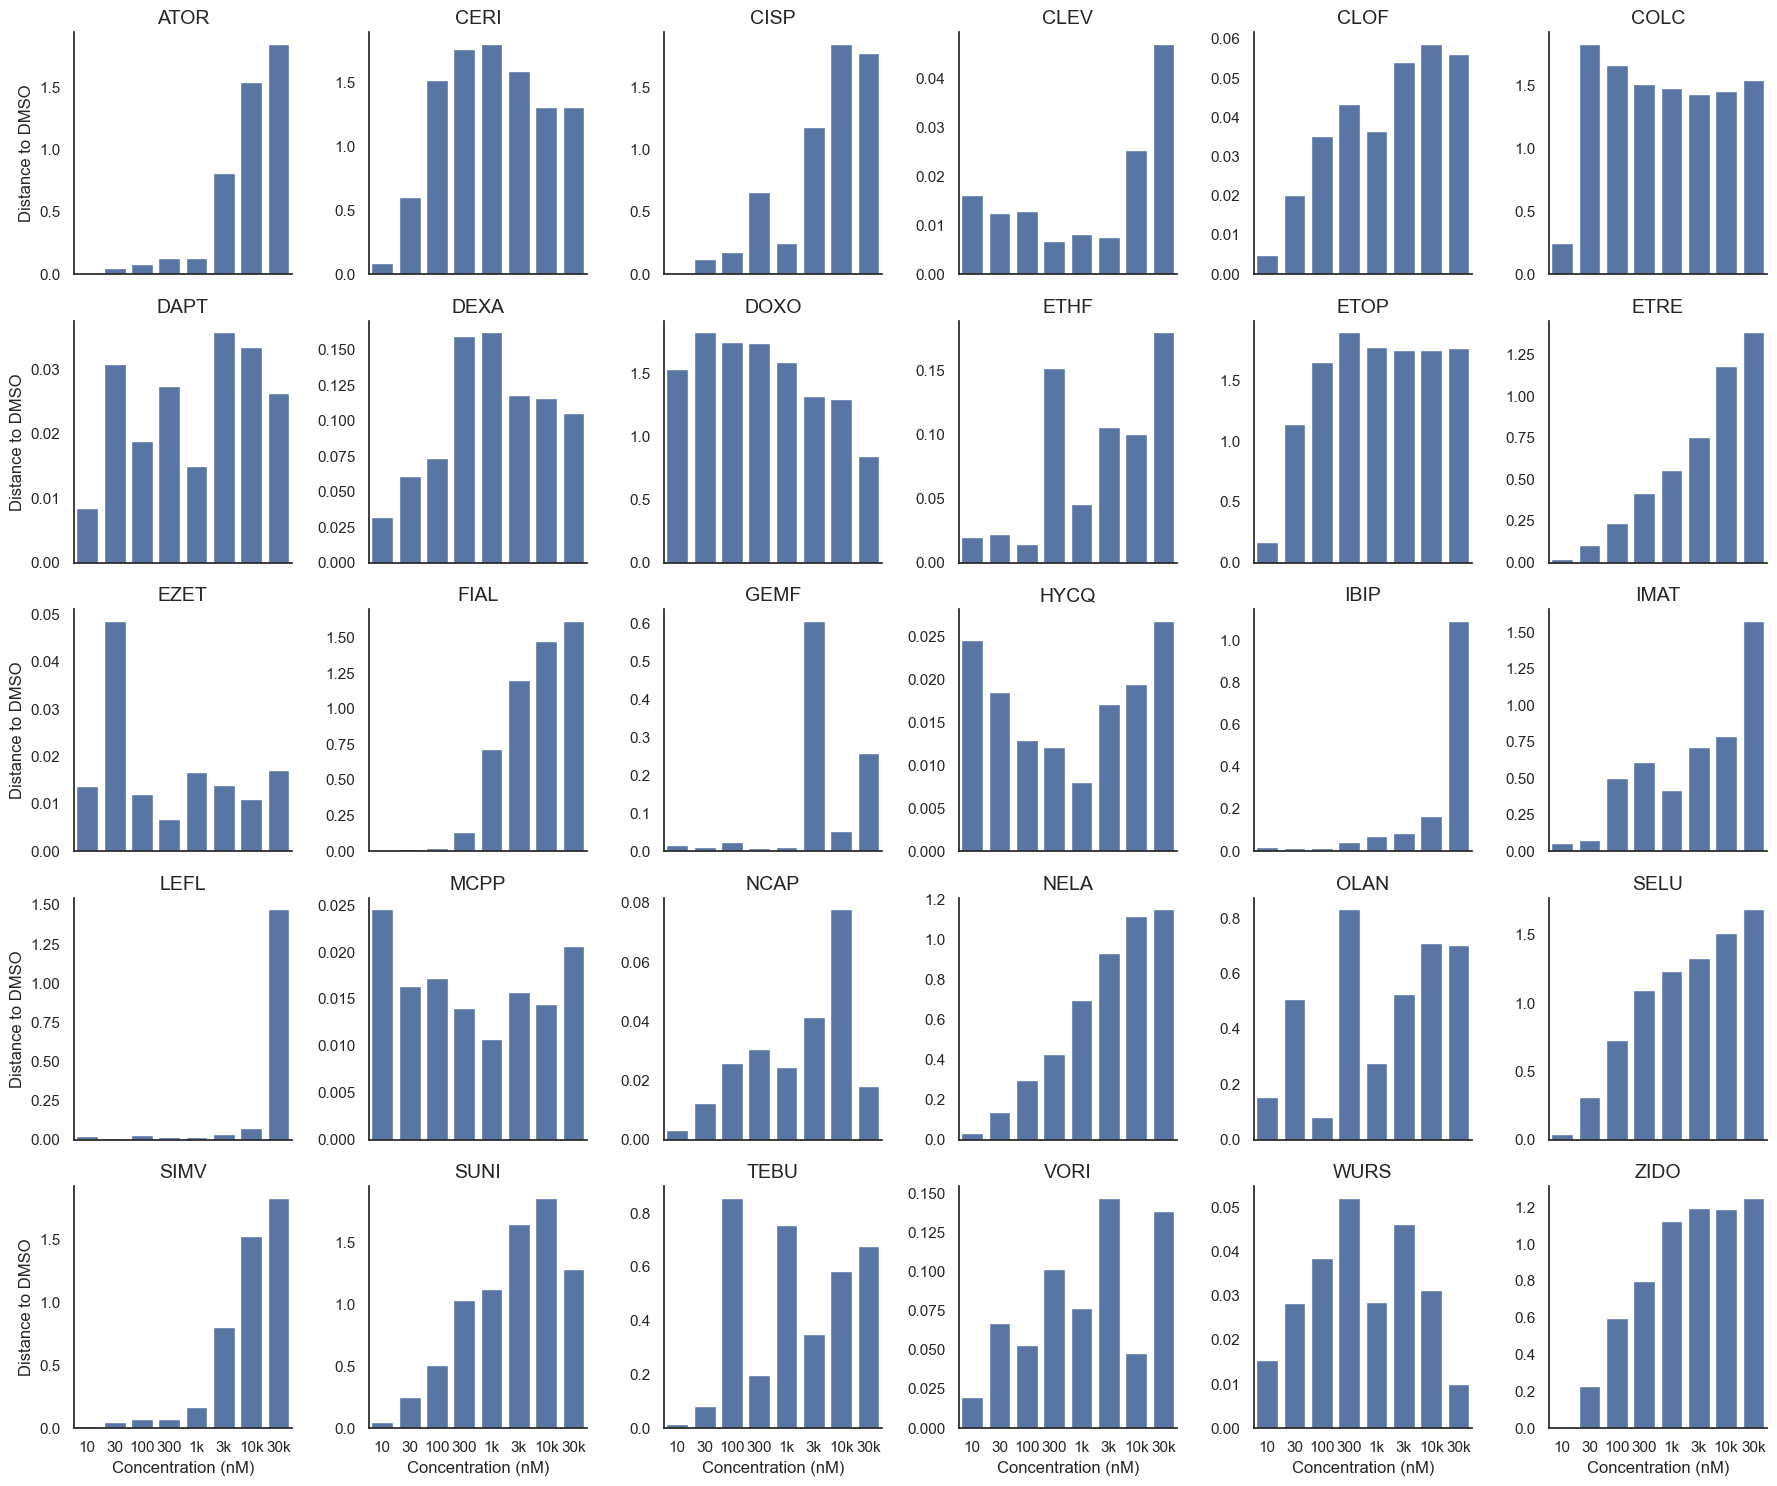

In [ ]:
### display distance of profiles to DMSO average
distToDMSO = pearsonDF.loc['DMSO'].T
distToDMSO.reset_index(inplace=True)
distToDMSO['Concentration (nM)'] = distToDMSO['Concentration'].replace({0:1}) #avoid log scale issue with c=0
distToDMSO = distToDMSO[distToDMSO.Compound != 'DMSO']
distToDMSO = distToDMSO.rename(columns={0 : "Distance to DMSO"})

g = sns.FacetGrid(distToDMSO, col='Compound',col_wrap=6,sharey=False,sharex=True)
g.map_dataframe(sns.barplot, x="Concentration (nM)", y='Distance to DMSO')
g.tick_params(axis='x', labelrotation = 0)
g.set_xticklabels(['10','30','100','300','1k','3k','10k','30k'])
g.set_titles(col_template = '{col_name}',size=14)
